In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision albumentations matplotlib tqdm tifffile


Mounted at /content/drive


In [2]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.optim as optim


In [3]:
class MicroplasticSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.images = sorted([
            file for file in os.listdir(image_dir)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))
        ])
        self.mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(mask_dir)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_base_name = os.path.splitext(img_name)[0]
        img_path = os.path.join(self.image_dir, img_name)

        mask_filename = self.mask_files.get(img_base_name)
        if mask_filename is None:
            raise FileNotFoundError(f"Mask file not found for image: {img_name}")

        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 127).astype('float32')  # binary mask

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # Add channel dimension
        else:
            image = T.ToTensor()(image)
            mask = torch.tensor(mask).unsqueeze(0)

        return image, mask


In [4]:
train_image_dir = '/content/drive/MyDrive/coral_dataset/archive (7)/train'
train_mask_dir = '/content/drive/MyDrive/coral_dataset/archive (7)/train'

valid_image_dir = '/content/drive/MyDrive/coral_dataset/archive (7)/valid'
valid_mask_dir = '/content/drive/MyDrive/coral_dataset/archive (7)/valid'

train_transforms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_dataset = MicroplasticSegDataset(train_image_dir, train_mask_dir, transforms=train_transforms)
valid_dataset = MicroplasticSegDataset(valid_image_dir, valid_mask_dir, transforms=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")


Train samples: 577
Validation samples: 204


In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = CBR(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        up4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat([up4, enc4], 1))
        up3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], 1))
        up2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], 1))
        up1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], 1))
        return torch.sigmoid(self.conv_last(dec1))


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Training on device: cpu


In [7]:
def iou(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    outputs = (outputs > threshold)
    labels = (labels > threshold)
    intersection = (outputs & labels).float().sum((1, 2, 3))
    union = (outputs | labels).float().sum((1, 2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()


In [8]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)


In [9]:
def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    ious = []
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validating"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
            ious.append(iou(outputs, masks))
    return epoch_loss / len(dataloader), np.mean(ious)


In [10]:
checkpoint_dir = '/content/drive/MyDrive/microplastic_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


In [11]:
def load_checkpoint(model, optimizer, checkpoint_dir=checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    if not checkpoints:
        return 0  # No checkpoint found
    latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    path = os.path.join(checkpoint_dir, latest_checkpoint)
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint['epoch']

In [12]:
num_epochs = 20
start_epoch = load_checkpoint(model, optimizer, checkpoint_dir)

for epoch in range(start_epoch, num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_iou = eval_epoch(model, valid_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f} — Val IoU: {val_iou:.4f}")

    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_iou': val_iou,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")


Loaded checkpoint from epoch 20


In [13]:
torch.save(model.state_dict(), '/content/drive/MyDrive/unet_microplastic_final.pth')
print("Model saved successfully.")


Model saved successfully.


Saving plastic2.jpg to plastic2.jpg


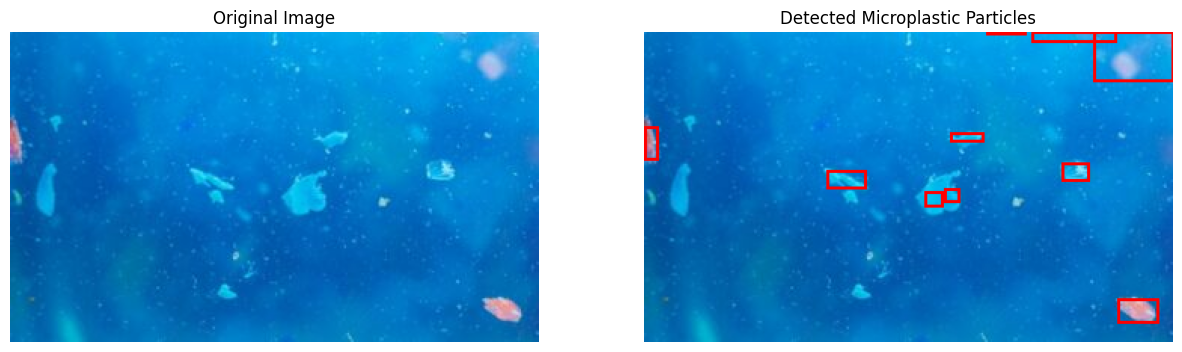

In [14]:
from google.colab import files
import cv2
from PIL import Image, ImageDraw


# Set device and load model weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
checkpoint_path = '/content/drive/MyDrive/unet_microplastic_final.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Upload an image for testing
uploaded = files.upload()
image_path = next(iter(uploaded))

# Preprocessing transform (must match training)
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Load and preprocess the uploaded image
img = Image.open(image_path).convert('RGB')
img_np = np.array(img)
augmented = transform(image=img_np)
input_tensor = augmented['image'].unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    pred_mask = model(input_tensor)[0][0].cpu().numpy()

# Threshold mask to binary
mask = (pred_mask > 0.5).astype(np.uint8)

# Resize mask to original image size
mask_resized = cv2.resize(mask, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

# Find contours of detected microplastic regions
contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw red bounding boxes for each detected microplastic particle
img_with_boxes = img.copy()
draw = ImageDraw.Draw(img_with_boxes)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w * h > 50:  # filter out very small regions; adjust threshold if needed
        draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

# Show original and annotated images side by side
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Detected Microplastic Particles')
plt.imshow(img_with_boxes)
plt.axis('off')

plt.show()